# Tech 2025 Lab
### Lab A - Loan Risk AI Agent
An **AI Agent** refers to a system or program that is capable completing a request by first planning the sequence of workflow steps and then performing the tasks in the steps by utilizing available tools. AI agents utilizes large language models (LLM) to understand the context of the request, plan and perform the tasks. 

This Python Notebook provides the code to create a simple AI agent for risk and interest rate evaluation in a bank loan processing scenario. It uses LangGraph graph for state and runtime processing. Once created, you assume the persona of a loan risk analyst at a bank and ask the Loan Risk AI Agent questions in natural language to assess risks for customers. When a question is asked, the AI agent will use a LLM to understand the context, determine the seqence of steps, and then complete the steps utilizing availble tools. The tools fetch customer information, credit score, account status and determine risk and interest rate. The sequence of steps, tool calling and final response can be reviewed in the output.

#### To use this Notebook:

Run each cell below one by one and make sure it completes successfully.

When prompted for API key enter it in the box and hit Enter and then continue running the cells to initialize the code.

Finally, when prompted enter your query and run the subsequent cells. Some example questions are provided.

You may run/repeat the query cells by entering and trying different queries.

#### Lab A - Exercise 1
Below is an outline of the code. The code is set up in Python Notebook cells.

1. Set up required libraries
2. Define functions to get and check credentials
3. Define tools that the AI agent can use
4. Configure the LLM
5. Define the LangGraph graph and functions for state and runtime processing.
6. Show a visual representation the graph - the AI agent with tools
7. Use the AI agent - ask the AI agent risk related question
8. Review the responses from AI agent risk

#### Lab A - Exercise 2
1. Add another tool that can provide interest rate.
2. Use the AI agent - ask the AI agent risk and interest rate related question
3. Review the responses from AI agent risk


#### Lab A - Exercise 3 (Optional)
1. Update the overall risk and interest rate tools to use RAG (retrieval augmented generation) pattern based query determine risk and interest rate.
2. Use the AI agent - ask the AI agent risk and interest rate related question
3. Review the responses from AI agent risk


~TBD cell bookmarks for above. Example, not working.

<a href='#lab_a_exercise_2'>Lab A - Exercise 2</a>

[Lab A - Exercise 2](#lab_a_exercise_2)


### Lab A - Exercise 1

#### 1. Set up required libraries

In [29]:
# Set up libraries
%pip install langgraph==0.2.73
%pip install -U langchain-ibm==0.3.6
    
from typing import Annotated, Literal, TypedDict

from langchain_core.messages import HumanMessage

from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode

import requests
import json
import time
import random

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


#### 2. Define functions to get and check credentials

In [30]:
# Function to get credentials
import getpass
import os

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

# Get credentials
# Set the Project IDs
# If using you own account, or lab account and project, the current project id will be configured and set automtically
_set_if_undefined("PROJECT_ID")

# When prompted for API key enter it in the box and hit Enter, move to next cell and then continue running the cells
_set_if_undefined("WATSONX_API_KEY")


In [ ]:
# Print credential configurations for validation
print('Api key:',os.environ.get("WATSONX_API_KEY"))
print('Project id:',os.environ.get("PROJECT_ID"))

#### 3. Define tools that the AI agent can use

In [32]:
# Define tools that the AI agent can use

# The tool get_customer_info() simulates/mocks API call that fetches credit score and account status information about a customer
# The tools get_credit_score() and get_account_status() use the customer info tool to get the score and account status
# The customer's loan risk is determined based on credit score and account status risk rules using get_overall_risk() tool
# When a natural language question is asked, the AI agent first determines the context and then the sequence to utilize one or more tools to provide a response 

# this tool simulates an API call that will fetch information about customers
@tool
def get_customer_info(customer_id: str): 
    """Retrieve customer information based on the customer_id."""
    customer_id = customer_id.lower()
    
    if customer_id in ['loren@ibm.com', 'loren', '1111']:
        return {'credit_score': 455, 'account_status': 'good-standing'}
    elif customer_id in ['matt@ibm.com', 'matt', '2222']:
        return {'credit_score': 685, 'account_status': 'closed'}
    elif customer_id in ['hilda@ibm.com', 'hilda', '3333']:
        return {'credit_score': 825, 'account_status': 'delinquent'}
    else:
        #return {'credit_score': None, 'account_status': None}
        #if any other customer id is used, provide a random credit score and account status
        return {'credit_score': random.randint(300, 850), 'account_status': random.choice(['delinquent', 'good-standing', 'closed' ])}



# this tool fetches credit score of a customer
@tool
def get_credit_score(customer_id: str) -> int: 
    """Get the credit score for the customer using customer_id. Customer's name can be used instead of customer_id."""
    customer_info = get_customer_info(customer_id)
    return customer_info['credit_score']
    customer_id = customer_id.lower()


# this tool fetches account status of a customer
@tool
def get_account_status(customer_id: str) -> str: 
    """Get the account status for the customer using customer_id. Customer's name can be used instead of customer_id."""
    customer_info = get_customer_info(customer_id)
    return customer_info['account_status']
    customer_id = customer_id.lower()

# this tool determines the overall risk for a customer
@tool
def get_overall_risk(credit_score: int, account_status: str):
    """Get overall risk based on combination of both credit score and account status. Only use high, medium or low as risk categories. Explain how the overall risk was calculated. If the credit score and account status are unknown then do not provide the risk status and first retrieve the missing credit score or account status."""

    #print("get_overall_risk():credit score:account status::", credit_score, account_status)
    
    if (credit_score > 299 & credit_score < 674): 
        if (account_status == 'delinquent'): overall_risk = 'high'
        elif (account_status == 'closed'):  overall_risk = 'high'
        elif (account_status == 'good-standing'):  overall_risk = 'medium'
        else: overall_risk = 'unkown'
    
    elif (credit_score >= 675 & credit_score < 749): 
        if (account_status == 'delinquent'): overall_risk = 'high'
        elif (account_status == 'closed'):  overall_risk = 'medium'
        elif (account_status == 'good-standing'):  overall_risk = 'medium'
        else: overall_risk = 'unkown'

    elif (credit_score >= 750 & credit_score < 851): 
        if (account_status == 'delinquent'): overall_risk = 'high'
        elif (account_status == 'closed'):  overall_risk = 'low'
        elif (account_status == 'good-standing'):  overall_risk = 'low'
        else: overall_risk = 'unkown'
    

    else: overall_risk = 'unable to determine.'    
    return overall_risk

# Set the list of tools to be used by the AI agent
tools = [get_credit_score, get_account_status, get_overall_risk, get_customer_info]

tool_node = ToolNode(tools)



#### 4. Configure the LLM

In [33]:
#Configure the LLM

from ibm_watsonx_ai.metanames import GenTextParamsMetaNames
parameters = {
    GenTextParamsMetaNames.DECODING_METHOD: "sample", #"greedy", #"sample"
    GenTextParamsMetaNames.MIN_NEW_TOKENS: 150,
    GenTextParamsMetaNames.MAX_NEW_TOKENS: 250,
    GenTextParamsMetaNames.TEMPERATURE: 0,
    #GenTextParamsMetaNames.TOP_K: 50,
    #GenTextParamsMetaNames.TOP_P: 1,
}

from langchain_ibm import ChatWatsonx
model = ChatWatsonx(
    model_id="mistralai/mistral-large", 
    url="https://us-south.ml.cloud.ibm.com", 
    #url="https://eu-de.ml.cloud.ibm.com", 
    apikey=os.environ.get("WATSONX_API_KEY"),
    project_id=os.environ.get("PROJECT_ID"),
    params=parameters,
).bind_tools(tools)

#### 5. Define the LangGraph graph and functions for state and runtime processing.

In [34]:
# Define the function that determines whether to continue or not
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return END


# Define the function that calls the model
def call_model(state: MessagesState):
    messages = state['messages']
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}



In [35]:
# Define a new graph
workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

# add a normal edge from `tools` to `agent`.
# after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", 'agent')


# Compile graph
app = workflow.compile()


#### 6. Show a visual representation the graph - the AI agent with tools

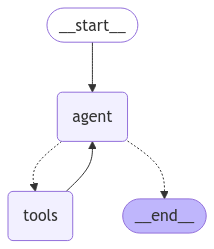

In [36]:
# Show graph
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

#### 7. Use the AI agent - ask the AI agent risk related question



Ask the AI agent these questions. Review the response.

- what can you do for me?
- what can you do for me? how?

- what is the risk for matt?
 
- what is the risk for matt? explain why?

- tell me about hilda?
  
- what is the risk for hilda? explain why?

- what is the risk for credit score 774 and account status delinquent?

- what is the risk for credit score 774 and account status delinquent? how was it determined?

Also try asking questions about interest rate....

- what is the interest rate for matt?

- what is the interest rate for matt? explain how it was determined?

For the last two questions, note that there is no tool yet that provides interest rate. So the response does not answer the question appropriately. 
We will add interest rate tool in the next exercise.

#### Write the query in the box and hit Enter and then continue running the next cells

In [37]:
human_query = input("Type a question and hit enter: ")

Type a question and hit enter:  what is the interest rate for matt? explain how it was determined?


In [38]:
# Use the runtime
final_state = app.invoke(
    #{"messages": [HumanMessage(content="what is the overall risk?")]},
    {"messages": [HumanMessage(content=human_query)]},
    config={"configurable": {"thread_id": random.randint(1, 100)}}
)

#final_state["messages"][-1].content

for m in final_state["messages"]:
    m.pretty_print()

#Print final message
#final_state["messages"][-1].content


================================ Human Message =================================

what is the interest rate for matt? explain how it was determined?
================================== Ai Message ==================================
Tool Calls:
  get_customer_info (0gEdZwXvA)
 Call ID: 0gEdZwXvA
  Args:
    customer_id: matt
================================= Tool Message =================================
Name: get_customer_info

{"credit_score": 685, "account_status": "closed"}
================================== Ai Message ==================================
Tool Calls:
  get_overall_risk (SE92znhWL)
 Call ID: SE92znhWL
  Args:
    credit_score: 685
    account_status: closed
================================= Tool Message =================================
Name: get_overall_risk

high
================================== Ai Message ==================================

 The overall risk for Matt is high. This is determined by considering both the credit score and account status. A credit score 

#### 8. Review the response above from AI agent risk
Run/repeat the above cells with different queries, i.e., rerun the human_query and final_state = app.invoke() cells with different queries

<a id='lab_a_exercise_2'></a>
### Lab A - Exercise 2


So far we had tool that provided the risk level for a customer - as low, medium or high. There was no tool to provide a specific interest rate.
In this exercise we will add another tool that can provide the interest rate based on the risk level.


In [40]:
# this tool determines the interest rate for a customer
@tool
def get_interest_rate(overall_risk: str):
    """Get interest rate percentage based on the overall risk. If the overall risk is not known then do not provide the interest rate and first retrieve the missing overall risk."""
    if (overall_risk.lower() == "high"):
        interest_rate=10.75;
    
    elif (overall_risk.lower() == "medium"):
        interest_rate=5.25;

    elif (overall_risk.lower() == "low"):
        interest_rate=3.0;
    
    else: interest_rate = 'unable to determine.'    
    return interest_rate


# Lets add/include this tool in the list of tools used by the AI agent in the following code line "tools =..."
tools = [get_credit_score, get_account_status, get_overall_risk, get_interest_rate, get_customer_info]
tool_node = ToolNode(tools)

In [41]:
# Re-bind the model configuration with new tools

from ibm_watsonx_ai.metanames import GenTextParamsMetaNames
parameters = {
    GenTextParamsMetaNames.DECODING_METHOD: "sample", #"greedy", #"sample"
    GenTextParamsMetaNames.MIN_NEW_TOKENS: 150,
    GenTextParamsMetaNames.MAX_NEW_TOKENS: 250,
    GenTextParamsMetaNames.TEMPERATURE: 0,
    #GenTextParamsMetaNames.TOP_K: 50,
    #GenTextParamsMetaNames.TOP_P: 1,
}

from langchain_ibm import ChatWatsonx
model = ChatWatsonx(
    model_id="mistralai/mistral-large", 
    url="https://us-south.ml.cloud.ibm.com", 
    #url="https://eu-de.ml.cloud.ibm.com", 
    apikey=os.environ.get("WATSONX_API_KEY"),
    project_id=os.environ.get("PROJECT_ID"),
    params=parameters,
).bind_tools(tools)

In [42]:
# Re-define the function that determines whether to continue or not
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return END


# Re-define the function that calls the model
def call_model(state: MessagesState):
    messages = state['messages']
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [43]:
# Re-define a new graph with new tools
workflow = StateGraph(MessagesState)

# Re-define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

# add a normal edge from `tools` to `agent`.
# after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", 'agent')


# Re-compile graph
app = workflow.compile()



Ask the AI agent questions about interest rate. Review the response.

 
- what is the interest rate for matt?

- what is the interest rate for matt? explain how it was determined?

Note that how the AI agent can now use the get_interest_rate to provide interest rate also.

#### Write the query in the box and hit Enter and then continue running the next cells

In [44]:
human_query = input("Type a question and hit enter: ")


Type a question and hit enter:  what is the interest rate for matt? explain how it was determined?


In [45]:
# Use the runtime
final_state = app.invoke(
    #{"messages": [HumanMessage(content="what is the overall risk?")]},
    {"messages": [HumanMessage(content=human_query)]},
    config={"configurable": {"thread_id": random.randint(1, 100)}}
)

#final_state["messages"][-1].content

for m in final_state["messages"]:
    m.pretty_print()

#Print final message
#final_state["messages"][-1].content

================================ Human Message =================================

what is the interest rate for matt? explain how it was determined?
================================== Ai Message ==================================
Tool Calls:
  get_customer_info (MxwzVlSyy)
 Call ID: MxwzVlSyy
  Args:
    customer_id: matt
================================= Tool Message =================================
Name: get_customer_info

{"credit_score": 685, "account_status": "closed"}
================================== Ai Message ==================================
Tool Calls:
  get_overall_risk (cyhA7Rzsg)
 Call ID: cyhA7Rzsg
  Args:
    credit_score: 685
    account_status: closed
================================= Tool Message =================================
Name: get_overall_risk

high
================================== Ai Message ==================================
Tool Calls:
  get_interest_rate (8S8EUh32D)
 Call ID: 8S8EUh32D
  Args:
    overall_risk: high
=================================

### Lab A - Exercise 3 (Optional) 

### ***** this exercise will be made demo only due to time constraints and complexities in creating RAG deployments and endpoints in every project ****

In this exercise will use RAG (retrieval augmented generation) pattern based query determine risk and interest rate. Instead of conditions defined in the tool,  content in the published risk and interest rate documents will be used to determine the risk and interest rate. 
For reference, these documents can be found here. They were used to create embeddings and vector index for RAG querying.
The RAG URL endpoint to get risk and interest rate was pre-created and will be called from the new tools.

IN the following cells, we will create new rag llm based risk and interest rate tools and set up the AI agent to use them.


In [22]:
# Calling the RAG LLM endpoint requires a bearer token. First we will create the code that will be used to get the IBM IAM bearer token from API key
# Function to get IBM IAM bearer token
os.environ["IBM_IAM_ACCESS_TOKEN_EXPIRATION"]="1" #must be initialized for validaiton purposes
def get_ibm_iam_token() -> str: 
    epoch_time = int(time.time())
    #print(epoch_time)
    if ( int(os.environ["IBM_IAM_ACCESS_TOKEN_EXPIRATION"]) < epoch_time):
        #print("IBM_IAM_ACCESS_TOKEN expired.")
    
        #get new token
        url = "https://iam.cloud.ibm.com/identity/token"
        headers = {'Content-Type': 'application/x-www-form-urlencoded'}
        data = 'grant_type=urn:ibm:params:oauth:grant-type:apikey&apikey='+os.environ.get("WATSONX_API_KEY")
        try:
            response = requests.post(url, data=data, headers=headers)
            response.raise_for_status()
            #print(response.json())
            os.environ["IBM_IAM_ACCESS_TOKEN"]=response.json()["access_token"]
            os.environ["IBM_IAM_ACCESS_TOKEN_EXPIRATION"]=str(response.json()["expiration"])
    
        except requests.exceptions.RequestException as e:
            print(f"An error occurred: {e}")
    
    #else:
        #print("IBM_IAM_ACCESS_TOKEN is valid.")
        #print("IBM_IAM_ACCESS_TOKEN:",os.environ["IBM_IAM_ACCESS_TOKEN"])
        #print("IBM_IAM_ACCESS_TOKEN_EXPIRATION:",os.environ["IBM_IAM_ACCESS_TOKEN_EXPIRATION"])

    return os.environ["IBM_IAM_ACCESS_TOKEN"]
#print(get_ibm_iam_token())

In [23]:
# this tool determines the overall risk for a customer using a RAG endpoint
@tool
def get_overall_risk_from_rag_llm(credit_score:int, account_status:str):
    """Get overall risk based on combination of both credit score and account status. Explain how the overall risk was calculated. If the credit score and account status are not known then do not provide the risk status and first retrieve the missing credit score or account status."""
    rag_url = "https://us-south.ml.cloud.ibm.com/ml/v4/deployments/61b4776a-a77d-457e-b44d-c83a3b3456ad/ai_service?version=2021-05-01"
    headers = {'Content-type': 'application/json', 'Authorization': 'Bearer ' + get_ibm_iam_token() }
    llm_rag_query="what is the risk for credit score " + str(credit_score) + " and account status " + account_status + ", and how is it determined?",
    data = {"messages": [{"content": llm_rag_query,"role": "user" }]}
    
    try:
        response = requests.post(rag_url, data=json.dumps(data), headers=headers)
        response.raise_for_status()
        #print(response.json())
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")

    return response.json()["choices"][0]["message"]["content"]

# this tool determines the interest rate for a customer using a RAG endpoint
@tool
def get_interest_rate_from_rag_llm(overall_risk:str):
    """Get interest rate percentage based on overall risk. If the overall risk is not known then do not provide the interest rate status and first retrieve the overall risk. Explain how the interest rate was determined."""

    rag_url = "https://us-south.ml.cloud.ibm.com/ml/v4/deployments/61b4776a-a77d-457e-b44d-c83a3b3456ad/ai_service?version=2021-05-01"
    headers = {'Content-type': 'application/json', 'Authorization': 'Bearer ' + get_ibm_iam_token() }
    llm_rag_query="what is the interest rate for overall risk " + overall_risk + ", and how is it determined?",
    data = {"messages": [{"content": llm_rag_query,"role": "user" }]}
    
    try:
        response = requests.post(rag_url, data=json.dumps(data), headers=headers)
        response.raise_for_status()
        #print(response.json())
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")

    return response.json()["choices"][0]["message"]["content"]


# Set the list of tools to be used by the AI agent - - we change the risk and interest rate tools to use the ones with rag_llm
tools = [get_credit_score, get_account_status, get_overall_risk_from_rag_llm, get_interest_rate_from_rag_llm, get_customer_info]

tool_node = ToolNode(tools)


In [24]:
# Re-bind the model configuration with new tools
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames
parameters = {
    GenTextParamsMetaNames.DECODING_METHOD: "sample", #"greedy", #"sample"
    GenTextParamsMetaNames.MIN_NEW_TOKENS: 150,
    GenTextParamsMetaNames.MAX_NEW_TOKENS: 250,
    GenTextParamsMetaNames.TEMPERATURE: 0,
    #GenTextParamsMetaNames.TOP_K: 50,
    #GenTextParamsMetaNames.TOP_P: 1,
}

from langchain_ibm import ChatWatsonx
model = ChatWatsonx(
    model_id="mistralai/mistral-large", 
    url="https://us-south.ml.cloud.ibm.com", 
    #url="https://eu-de.ml.cloud.ibm.com", 
    apikey=os.environ.get("WATSONX_API_KEY"),
    project_id=os.environ.get("PROJECT_ID"),
    params=parameters,
).bind_tools(tools)

In [25]:
# Re-define the function that determines whether to continue or not
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return END


# Re-define the function that calls the model
def call_model(state: MessagesState):
    messages = state['messages']
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [26]:
# Re-define a new graph with new tools
workflow = StateGraph(MessagesState)

# Re-define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

# add a normal edge from `tools` to `agent`.
# after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", 'agent')


# Re-compile graph
app = workflow.compile()

Ask the AI agent questions about interest rate. Review the response.

 
- what is the interest rate for matt?

- what is the interest rate for matt? explain how it was determined?

Note that how the AI agent can uses _rag_llm tools, and the content in the published documents to provide risk and interest rate.
For reference, these documents can be found here. They were used to create embeddings and vecotr index.

#### Write the query in the box and hit Enter and then continue running the next cells

In [27]:
human_query = input("Type a question and hit enter: ")

Type a question and hit enter:  what is the interest rate for matt? explain how it was determined?


In [28]:
# Use the runtime
final_state = app.invoke(
    #{"messages": [HumanMessage(content="what is the overall risk?")]},
    {"messages": [HumanMessage(content=human_query)]},
    config={"configurable": {"thread_id": random.randint(1, 100)}}
)

#final_state["messages"][-1].content

for m in final_state["messages"]:
    m.pretty_print()

#Print final message
#final_state["messages"][-1].content

================================ Human Message =================================

what is the interest rate for matt? explain how it was determined?
================================== Ai Message ==================================
Tool Calls:
  get_customer_info (wes1atGTg)
 Call ID: wes1atGTg
  Args:
    customer_id: matt
================================= Tool Message =================================
Name: get_customer_info

{"credit_score": 685, "account_status": "closed"}
================================== Ai Message ==================================
Tool Calls:
  get_overall_risk_from_rag_llm (FLh7R0RV0)
 Call ID: FLh7R0RV0
  Args:
    credit_score: 685
    account_status: closed
================================= Tool Message =================================
Name: get_overall_risk_from_rag_llm

 To determine the risk for a credit score of 685 and an account status of "Closed," we need to refer to the "Bank Loan Overall Risk" table provided.

Here's the relevant part of the table: